In [1]:
!git clone -q https://github.com/Chandrahas-B/MLOps
%cd MLOps

fatal: destination path 'MLOps' already exists and is not an empty directory.
/content/MLOps


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("./diabetes-dataset.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [5]:
from sklearn.model_selection import train_test_split

def data_split(df, target, test_size):
  X,Y = df.drop([target], axis=1), df[target]
  x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size = test_size)
  train = pd.concat([x_train,y_train],axis=1)
  test = pd.concat([x_test,y_test],axis=1)
  print(x_train.shape, x_test.shape)
  return x_train, x_test, y_train, y_test

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

def preprocessing(df):
  for i in df.columns:
    if df[i].dtype == 'object':
      df[i] = df[i].fillna(df[i].mode())
      df[i] = le.fit_transform(df[i])
    else:
      df[i] = df[i].fillna(df[i].median())
  return df

In [7]:
df = preprocessing(df)
x_train, x_test, y_train, y_test = data_split(df, 'Outcome', 0.2)

(1600, 8) (400, 8)


### MODEL BUILDING

In [8]:
from lightgbm import LGBMClassifier as lgb
from sklearn.model_selection import RandomizedSearchCV

model = lgb()
num_iter = 15
model_params = {
    'num_leaves': np.arange(20, 100),
    'max_depth': np.arange(5, 15),
    'learning_rate': np.logspace(-3, 0, num = num_iter),
    'subsample': np.linspace(0.5, 1.0, num = num_iter),
    'colsample_bytree': np.linspace(0.5, 1.0, num = num_iter),
    'reg_alpha': np.linspace(0, 1, num = num_iter),
    'reg_lambda': np.linspace(0, 1, num = num_iter),
}

In [9]:
best_model = RandomizedSearchCV(model, param_distributions = model_params, n_iter = 75, cv = 5, random_state = 42)
hyperparameter_tuning = best_model.fit(x_train, y_train)

In [10]:
best_model.best_params_

{'subsample': 0.5714285714285714,
 'reg_lambda': 0.3571428571428571,
 'reg_alpha': 0.07142857142857142,
 'num_leaves': 55,
 'max_depth': 6,
 'learning_rate': 0.22758459260747887,
 'colsample_bytree': 0.7857142857142857}

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

train_pred = best_model.predict(x_train)
print("\t\tTRAIN:\n")
print(f"Accuracy: {accuracy_score(y_train, train_pred)}\n")
print(f"Classification report: \n {classification_report(y_train, train_pred)}")
train_cm = confusion_matrix(y_train, train_pred)
print(f"Confusion matrix: \n {confusion_matrix(y_train, train_pred)}")

		TRAIN:

Accuracy: 1.0

Classification report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1044
           1       1.00      1.00      1.00       556

    accuracy                           1.00      1600
   macro avg       1.00      1.00      1.00      1600
weighted avg       1.00      1.00      1.00      1600

Confusion matrix: 
 [[1044    0]
 [   0  556]]


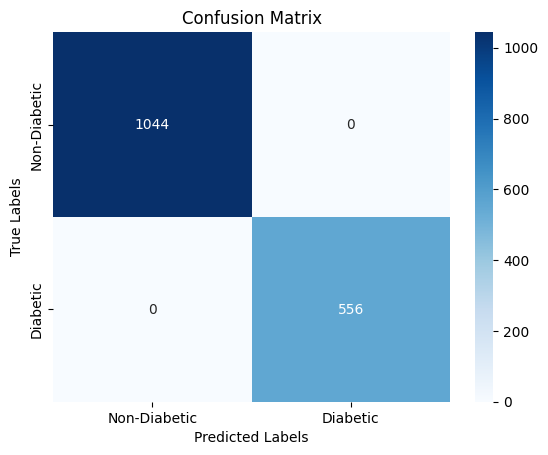

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(train_cm, annot=True, cmap='Blues', fmt='d')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

class_labels = ['Non-Diabetic', 'Diabetic']
ticks = np.arange(len(class_labels)) + 0.5
plt.xticks(ticks, class_labels)
plt.yticks(ticks, class_labels)
plt.show()

In [13]:
test_pred = best_model.predict(x_test)
print("\t\tTEST:\n")
print(f"Accuracy: {accuracy_score(y_test, test_pred)}\n")
print(f"Classification report: \n {classification_report(y_test, test_pred)}")
test_cm = confusion_matrix(y_test, test_pred)
print(f"Confusion matrix: \n {test_cm}")

		TEST:

Accuracy: 0.99

Classification report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       272
           1       0.98      0.98      0.98       128

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400

Confusion matrix: 
 [[270   2]
 [  2 126]]


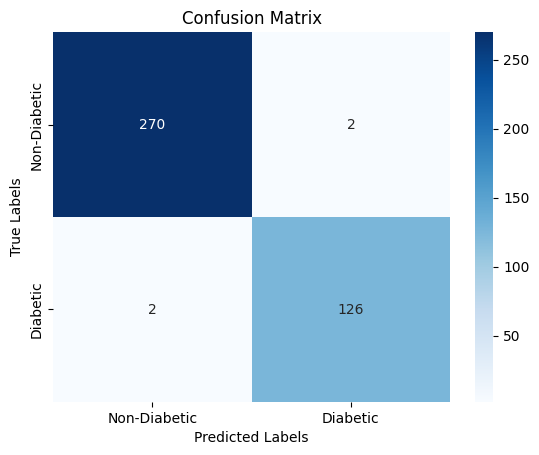

In [14]:
sns.heatmap(test_cm, annot=True, cmap='Blues', fmt='d')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

class_labels = ['Non-Diabetic', 'Diabetic']
ticks = np.arange(len(class_labels)) + 0.5
plt.xticks(ticks, class_labels)
plt.yticks(ticks, class_labels)
plt.show()

In [15]:
%cd ..

/content


In [16]:
import pickle

file_name = 'lightgbm.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(best_model.best_estimator_, f)

In [17]:
from google.colab import files

files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>